### Tensor-based Cahn-Hilliard

In [1]:
import sys

import torch as tp
import pyro
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import cm as cm
plt.style.use("ggplot")

In [2]:
sys.path.insert(1, '..\\src\\cahnhilliard.py')
 ## Access local script
from demixing_2d import *

In [3]:
LogNormal = pyro.distributions.LogNormal
Normal    = pyro.distributions.Normal

In [4]:
GLOBAL_DEVICE = tp.device('cpu')
CUDA_DEVICE   = tp.device('cuda' if tp.cuda.is_available() else 'cpu')

In [5]:
theta_priors = {
    'a': LogNormal(-11.86, 0.1),
    'b': Normal(1.2e-4, 1e-6),
    'k': LogNormal(-0.35, 0.01)
}

def sample_priors(theta, fix=None, device=GLOBAL_DEVICE):
    samples = {}
    
    if fix is None:
        fix = {}
    for k in theta.keys():
        if k not in fix.keys():
            fix[k] = False

    for k,v in theta.items():
        if not fix[k]:
            samples[k] = pyro.sample(k, v).to(device)
        else:
            samples[k] = fix[k]
    return samples

In [6]:
true_theta = sample_priors(theta_priors)

In [7]:
def simulate(theta=None, nt=9, max_iter=1e4, seed=None, device=GLOBAL_DEVICE):
    params = Variables(
            theta = sample_priors(
                 {
                    'a': LogNormal(-11.86, 0.1),
                    'b': Normal(1.2e-4, 1e-6),
                    'k': LogNormal(-0.35, 0.01)
                },
                device=device
            ) if theta is None else theta
        )
    # Construct Cahn Hilliard simulation model
    model = CahnHilliard(params=params, dim=2, seed=seed, device=device)
    
    ts = np.linspace(0, max_iter, nt).astype(np.int)
    
    q, S0 = model.scattering()
    S = tp.zeros(S0.shape[0], nt)
    S[:,0] = S0
    
    t = 1
    for k in range(int(max_iter)):
        model.iterate()
        if (k+1) in ts:
            _, St = model.scattering()
            S[:,t] = St
            t+=1
    return ts, q, S

def plot_sample(ts, q, S, yscale='log', cname='Blues'):
    cmap = cm.get_cmap(cname)
    cmap = [cmap(z) for z in np.linspace(0, 1, len(ts))]
    
    _, ax = plt.subplots(1,1,figsize=(14,6))
    for i,t in enumerate(ts):
        ax.plot(q, S[:,i], '-', color=cmap[i])
    ax.set_yscale(yscale)
    ax.legend(labels=[str(t) for t in ts])

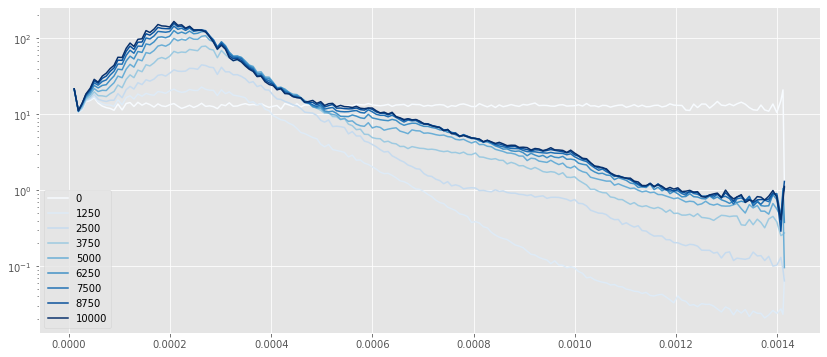

In [8]:
true_y = simulate(true_theta) # ts, q, S
plot_sample(*true_y)

In [10]:
true_theta

{'a': tensor(6.6348e-06), 'b': tensor(0.0001), 'k': tensor(0.6953)}

In [11]:
def sqdiff(y,y_):
    ''' (y-y')**2 '''
    return ((y - y_)**2).view(-1)
def mse(*args):
    return sqdiff(*args).mean()
def rmse(*args):
    return tp.sqrt(mse(*args))
def sse(*args):
    return sqdiff(*args).sum()

def loss(true_y, sim_y, metric=mse):
    return metric(true_y[2], sim_y[2])

In [12]:
grid = tp.linspace(0.01, 0.99, 30)

b, k = true_theta['b'], true_theta['k']

losses = []

for i, g in enumerate(grid):
    a = theta_priors['a'].icdf(g)
    test_theta = {'a':a, 'b':b, 'k':k}
    sample = simulate(test_theta)
    losses.append((test_theta, sample, loss(true_y, sample)))

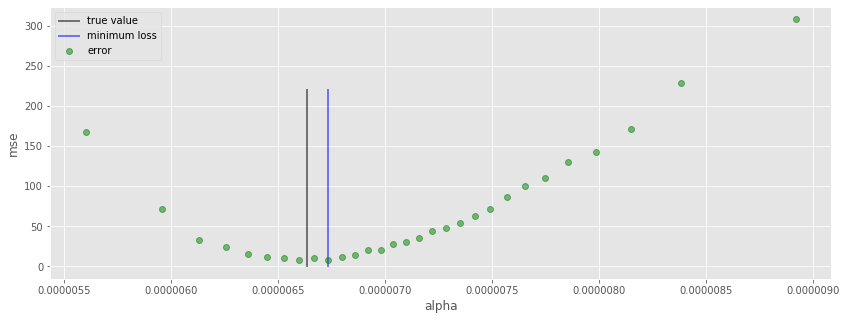

In [13]:
_, ax = plt.subplots(1,1,figsize=(14,5))
ax.set_xlabel('alpha')
ax.set_ylabel('mse')

min_i = np.argmin([experiment[2].cpu().numpy() for experiment in losses])

ax.plot([true_theta['a'].cpu().numpy(), true_theta['a'].cpu().numpy()],[0,220],'k-', lw=2, alpha=0.5)

ax.plot(
    [losses[min_i][0]['a'].cpu().numpy(), losses[min_i][0]['a'].cpu().numpy()],
    [0, 220],
    'b-',
    alpha=0.5, lw=2
)

for i,experiment in enumerate(losses):
    ax.plot(experiment[0]['a'].cpu().numpy(), experiment[2].cpu().numpy(),'go', alpha=0.5)
    
ax.legend(labels=["true value", "minimum loss", "error"])

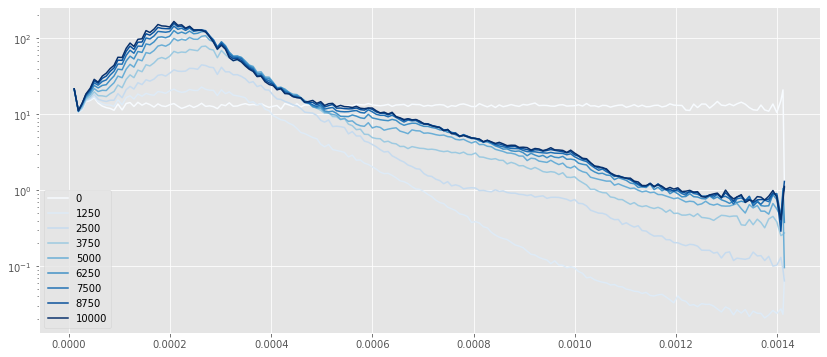

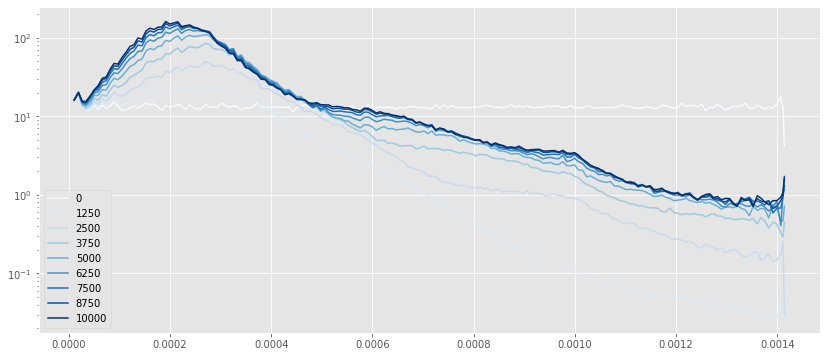

In [14]:
plot_sample(*true_y)
plot_sample(*losses[min_i][1])

### Bayesian optimisation

In [120]:
from GPyOpt.methods import BayesianOptimization

In [118]:
train_X = tp.linspace(0.01, 0.99, 5)[:,None]

fix_b, fix_k = true_theta['b'], true_theta['k']

losses = []

def f_of_(X,device=GLOBAL_DEVICE):
    a = theta_priors['a'].icdf(tp.tensor(X).to(device))
    sample = simulate({'a':a, 'b':fix_b, 'k':fix_k}, device=device)
    return loss(true_y, sample).cpu().item()

# train_Y = tp.tensor([f_of_(x) for x in train_X])

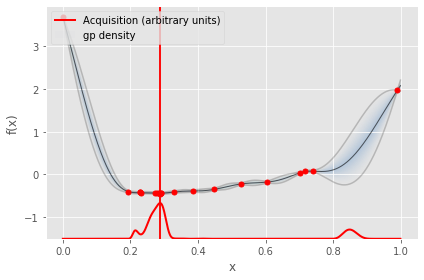

In [121]:
domain = [{'name': 'a', 'type':'continuous','domain':(0.0001, 0.9999)}]

experiment = BayesianOptimization(f = lambda x: f_of_(x), domain=domain)
experiment.run_optimization(max_iter=15)

In [197]:
a_mesh = np.linspace(5e-6, 9e-6, 100)
x_mesh = np.array([theta_priors['a'].cdf(tp.tensor(x)).cpu().item() for x in a_mesh])[:,None]

mu, var = experiment.model.model.predict(x_mesh)
sd = np.sqrt(var)

Text(0, 0.5, 'utility')

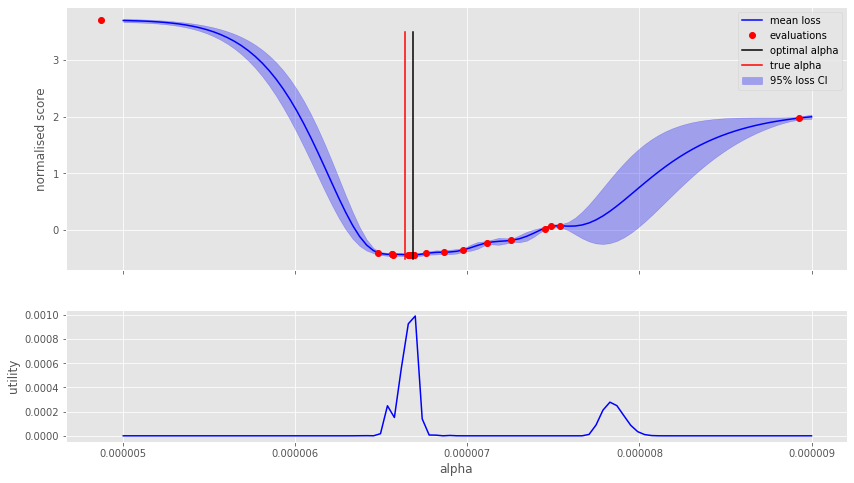

In [228]:
_, ax = plt.subplots(2,1, figsize=(14,8), gridspec_kw={'height_ratios':[2, 1]},sharex=True)
ax[0].plot(a_mesh, mu,'b-')
ax[0].fill_between(a_mesh, (mu-1.96*sd).ravel(), (mu+1.96*sd).ravel(), color='b', alpha=0.3)
ax[0].plot([theta_priors['a'].icdf(tp.tensor(x)) for x in experiment.model.model.X], experiment.model.model.Y,'ro')

ax[0].plot([theta_priors['a'].icdf(tp.tensor(experiment.x_opt))]*2,[-0.5, 3.5],'k-')
ax[0].plot([true_theta['a']]*2,[-0.5, 3.5],'r-')
ax[0].set_ylabel('normalised score')
ax[0].legend(labels=['mean loss', 'evaluations', 'optimal alpha','true alpha', '95% loss CI'])

ax[1].plot(a_mesh, -experiment.acquisition.acquisition_function(x_mesh),'b-')
# ax[1].plot([theta_priors['a'].icdf(tp.tensor(experiment.suggested_sample))]*2, [0., 0.001], 'g-')
ax[1].set_xlabel('alpha')
ax[1].set_ylabel('utility')
# ax[1].legend(labels=['utility function', 'suggested sample'])
